In [1]:
from PIL import Image
import torch
from torch.utils.data import DataLoader

In [2]:
from utils import frame_utils
# from utils.flow_viz import save_vis_flow_tofile
from glob import glob

In [3]:
from gmflow.gmflow import GMFlow
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [39]:
model1_path = "fb_inletvel_models/sintel_boil/checkpoint_latest.pth"
model2_path = "pretrained/gmflow_things-e9887eda.pth"
model1 = GMFlow(feature_channels=128,
                   num_scales=1,
                   upsample_factor=8,
                   num_head=1,
                   attention_type='swin',
                   ffn_dim_expansion=4,
                   num_transformer_layers=6,
                   ).to(device)
model2 = GMFlow(feature_channels=128,
                   num_scales=1,
                   upsample_factor=8,
                   num_head=1,
                   attention_type='swin',
                   ffn_dim_expansion=4,
                   num_transformer_layers=6,
                   ).to(device)

checkpoint1 = torch.load(model1_path, map_location='cuda:0')
checkpoint2 = torch.load(model2_path, map_location='cuda:0')

weights1 = checkpoint1['model'] if 'model' in checkpoint1 else checkpoint1
weights2 = checkpoint2['model'] if 'model' in checkpoint2 else checkpoint2

model1.load_state_dict(weights1)
model2.load_state_dict(weights2)

<All keys matched successfully>

In [40]:
model1.eval()
model2.eval()

GMFlow(
  (backbone): CNNEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
      

In [106]:
image_dir = "datasets/FB_InletVelocity/valid/inletVelScale-1.5/img"
gt_dir = "datasets/FB_InletVelocity/valid/inletVelScale-1.5/flow"

In [107]:
filenames = sorted(glob(image_dir + '/*'))
flonames = sorted(glob(gt_dir + '/*'))
print('%d images found' % len(flonames))

41 images found


In [108]:
import numpy as np

image1 = frame_utils.read_gen(filenames[15])
image2 = frame_utils.read_gen(filenames[16])
flow_gt = frame_utils.read_gen(flonames[15])
flow_gt = torch.from_numpy(flow_gt).permute(2, 0, 1).float()
flow_gt = flow_gt.unsqueeze(0)
flow_gt = flow_gt.cuda()

image1 = np.array(image1).astype(np.uint8)
image2 = np.array(image2).astype(np.uint8)

if len(image1.shape) == 2:  # gray image, for example, HD1K
    image1 = np.tile(image1[..., None], (1, 1, 3))
    image2 = np.tile(image2[..., None], (1, 1, 3))
else:
    image1 = image1[..., :3]
    image2 = image2[..., :3]

image1 = torch.from_numpy(image1).permute(2, 0, 1).float()
image2 = torch.from_numpy(image2).permute(2, 0, 1).float()

if torch.cuda.is_available():
    image1, image2 = image1[None].cuda(), image2[None].cuda()
else:
    image1, image2 = image1[None], image2[None]

results_dict_1 = model1(image1, image2,
                     attn_splits_list=[2],
                     corr_radius_list=[-1],
                     prop_radius_list=[-1],
                     pred_bidir_flow=False,
                     )
results_dict_2 = model2(image1, image2,
                     attn_splits_list=[2],
                     corr_radius_list=[-1],
                     prop_radius_list=[-1],
                     pred_bidir_flow=False,
                     )
flow_pr_1 = results_dict_1['flow_preds'][-1]  # [B, 2, H, W]
flow_pr_2 = results_dict_2['flow_preds'][-1]  # [B, 2, H, W]


In [109]:
epe_1 = torch.sum((flow_pr_1 - flow_gt) ** 2, dim=1).sqrt()
epe_2 = torch.sum((flow_pr_2 - flow_gt) ** 2, dim=1).sqrt()

In [110]:
epe_mag_1 = epe_1.cpu().detach().numpy()[0]
epe_mag_1 = epe_mag_1/epe_mag_1.max().item()
epe_mag_2 = epe_2.cpu().detach().numpy()[0]
epe_mag_2 = epe_mag_2/epe_mag_2.max().item()


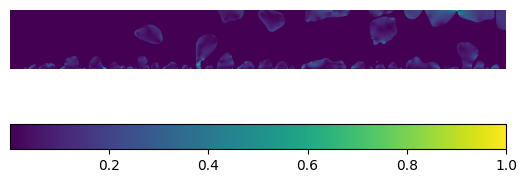

In [111]:
import matplotlib.pyplot as plt
plt.imshow(epe_mag_1)
plt.colorbar(location='bottom')
plt.axis('off')
plt.savefig("finetuned_error.png", bbox_inches='tight')

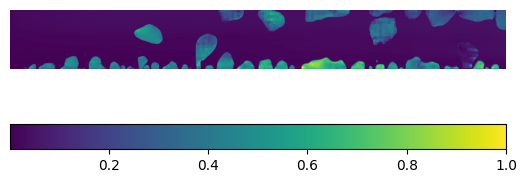

In [112]:
import matplotlib.pyplot as plt
plt.imshow(epe_mag_2)
plt.colorbar(location='bottom')
plt.axis('off')
plt.savefig("pretrained_error.png", bbox_inches='tight')

In [113]:
from torchvision.utils import flow_to_image
from torchvision.transforms import functional as F
flow_gt_img = flow_to_image(flow_gt).cpu().detach()
flow_pr_img_1 = flow_to_image(flow_pr_1).cpu().detach()
flow_pr_img_2 = flow_to_image(flow_pr_2).cpu().detach()


In [114]:
flow_gt_pil = F.to_pil_image(flow_gt_img[0])
flow_pr_pil_1 = F.to_pil_image(flow_pr_img_1[0])
flow_pr_pil_2 = F.to_pil_image(flow_pr_img_2[0])

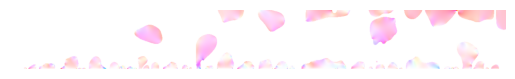

In [115]:
img = plt.imshow(flow_gt_pil)
plt.axis('off')
plt.savefig("flow_gt.png", bbox_inches='tight')

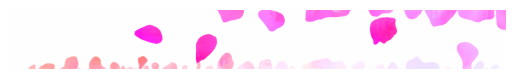

In [116]:
plt.imshow(flow_pr_pil_1)
plt.axis('off')
plt.savefig("finetuned.png", bbox_inches='tight')

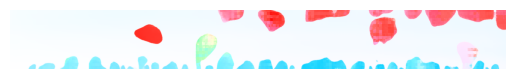

In [117]:
plt.imshow(flow_pr_pil_2)
plt.axis('off')
plt.savefig("pretrained.png", bbox_inches='tight')